# Load libraries

In [155]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## Load data

In [156]:
df = pd.read_csv('smartwatches.csv')
df.drop_duplicates(inplace=True)

train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Reset index after sampling to avoid potential issues with indexing
train_df = train_df.reset_index()
test_df = test_df.reset_index()

print(df.shape, train_df.shape, test_df.shape)

(450, 16) (360, 17) (90, 17)


In [157]:
train_df.head()

,index,Unnamed: 0,Brand,Current Price,Original Price,Discount Percentage,Rating,Number OF Ratings,Model Name,Dial Shape,Strap Color,Strap Material,Touchscreen,Battery Life (Days),Bluetooth,Display Size,Weight
0,407,407,zebronics,2949.0,4199.0,29.768993,3.1,10.0,LEATHER fit-650,Oval,Black,Leather,Yes,NaN,Yes,2.7 inches,NaN
1,444,444,fire-boltt,6999.0,15999.0,56.253516,2.6,NaN,bsw020,Circle,Brown,Silicon,Yes,8.0,Yes,1.4 inches,NaN
2,117,117,fire-boltt,2499.0,11999.0,79.173264,4.1,1990.0,BSW070,NaN,NaN,NaN,Yes,8.0,Yes,1.9 inches,75g +
3,30,30,boat,1999.0,7990.0,74.981227,3.6,827.0,NaN,NaN,NaN,NaN,NaN,8.0,Yes,NaN,75g +
4,415,415,fire-boltt,2299.0,5999.0,61.676946,2.5,24.0,NINJA PRO MAX,Square,Blue,Silicon,Yes,22.0,Yes,1.6 inches,NaN


In [158]:
train_df.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)
test_df.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [159]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                360 non-null    object 
 1   Current Price        354 non-null    float64
 2   Original Price       304 non-null    float64
 3   Discount Percentage  304 non-null    float64
 4   Rating               356 non-null    float64
 5   Number OF Ratings    315 non-null    float64
 6   Model Name           330 non-null    object 
 7   Dial Shape           260 non-null    object 
 8   Strap Color          260 non-null    object 
 9   Strap Material       304 non-null    object 
 10  Touchscreen          329 non-null    object 
 11  Battery Life (Days)  330 non-null    float64
 12  Bluetooth            355 non-null    object 
 13  Display Size         333 non-null    object 
 14  Weight               211 non-null    object 
dtypes: float64(6), object(9)
memory usage: 4

In [160]:
train_df.isnull().sum()

,0
Brand,0
Current Price,6
Original Price,56
Discount Percentage,56
Rating,4
Number OF Ratings,45
Model Name,30
Dial Shape,100
Strap Color,100
Strap Material,56


In [161]:
numerical_data = [feature for feature in train_df.columns if train_df[feature].dtype != 'object']

In [162]:
continuous_data = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']

In [163]:
numerical_data

['Current Price',
 'Original Price',
 'Discount Percentage',
 'Rating',
 'Number OF Ratings',
 'Battery Life (Days)']

In [164]:
continuous_data

['Brand',
 'Model Name',
 'Dial Shape',
 'Strap Color',
 'Strap Material',
 'Touchscreen',
 'Bluetooth',
 'Display Size',
 'Weight']

# Exploratory Data Analysis

## Univariate Analysis

Let's have a look at some of the variables.

**Brand**

In [89]:
train_df["Brand"].value_counts()

,count
Brand,
fire-boltt,45
noise,34
boat,30
zebronics,28
garmin,27
pebble,27
apple,24
dizo,22
samsung,21



**Strap Material**

In [90]:
train_df["Strap Material"].value_counts()

,count
Strap Material,
Silicon,197
Rubber,27
Other,16
Stainless Steel,14
Leather,12
Aluminium,11
Fluoroelastomer,10
Thermo Plastic Polyurethene,7
Fabric,3


In [91]:
train_df[numerical_data].describe()

,Current Price,Original Price,Discount Percentage,Rating,Number OF Ratings,Battery Life (Days)
count,354.000000,304.000000,304.000000,356.000000,315.000000,330.000000
mean,12514.378531,14415.835526,47.955347,4.027528,10671.815873,14.181970
std,16914.978666,15613.457236,24.696899,0.556828,27575.956948,7.661878
min,1199.000000,1669.000000,-79.688436,1.000000,1.000000,0.750000
25%,2126.000000,5999.000000,33.177427,3.900000,55.000000,8.000000
50%,3999.000000,7994.500000,53.068408,4.100000,830.000000,17.500000
75%,17367.250000,17996.000000,66.677780,4.300000,7576.500000,22.000000
max,98990.000000,96390.000000,91.004550,5.000000,275607.000000,22.000000


In [92]:
train_df[numerical_data].corr()

,Current Price,Original Price,Discount Percentage,Rating,Number OF Ratings,Battery Life (Days)
Current Price,1.000000,0.971497,-0.602668,0.397179,-0.195773,0.030352
Original Price,0.971497,1.000000,-0.479494,0.325818,-0.180650,-0.132527
Discount Percentage,-0.602668,-0.479494,1.000000,-0.191073,0.235221,-0.011792
Rating,0.397179,0.325818,-0.191073,1.000000,0.085250,-0.102289
Number OF Ratings,-0.195773,-0.180650,0.235221,0.085250,1.000000,0.009617
Battery Life (Days),0.030352,-0.132527,-0.011792,-0.102289,0.009617,1.000000


In [93]:
train_df[numerical_data].skew()

,0
Current Price,2.301689
Original Price,2.734265
Discount Percentage,-0.983632
Rating,-1.589043
Number OF Ratings,5.467630
Battery Life (Days),-0.190298


Histograms

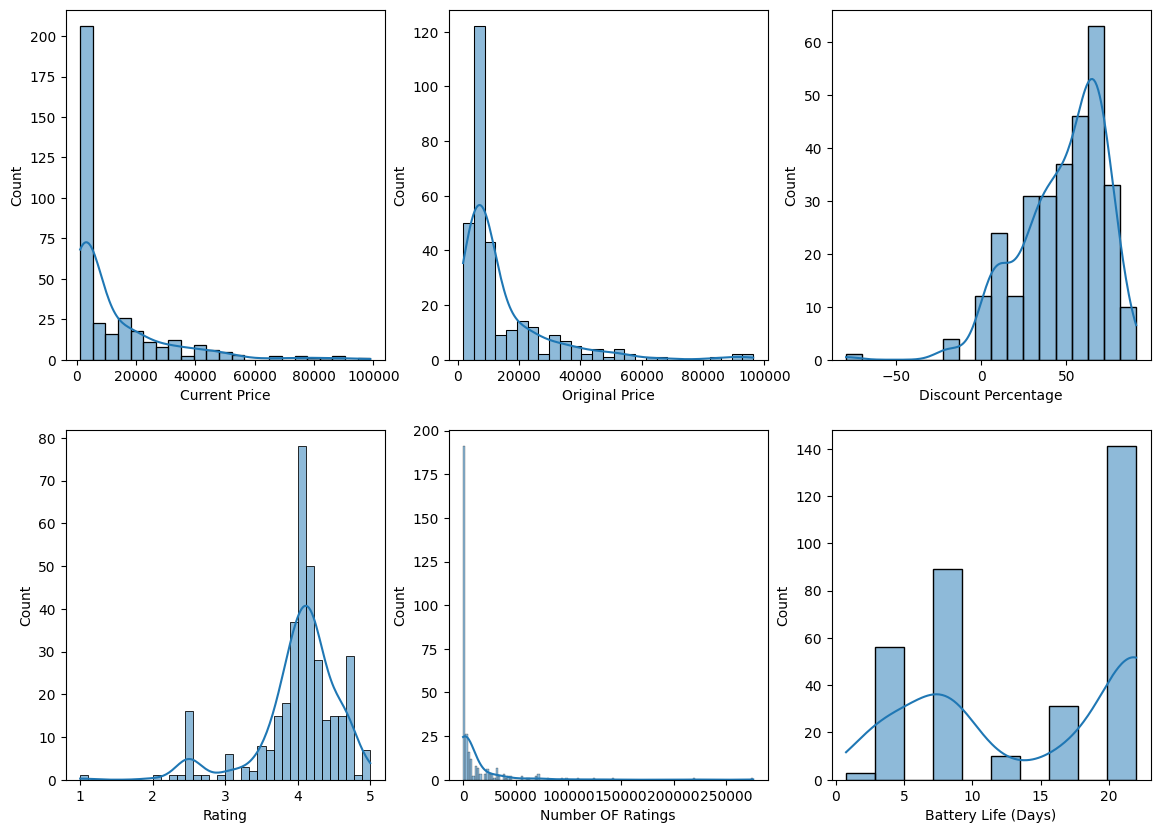

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))

for i, column in enumerate(numerical_data):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.histplot(data=train_df[column], ax=ax, kde=True)

plt.show()

Density

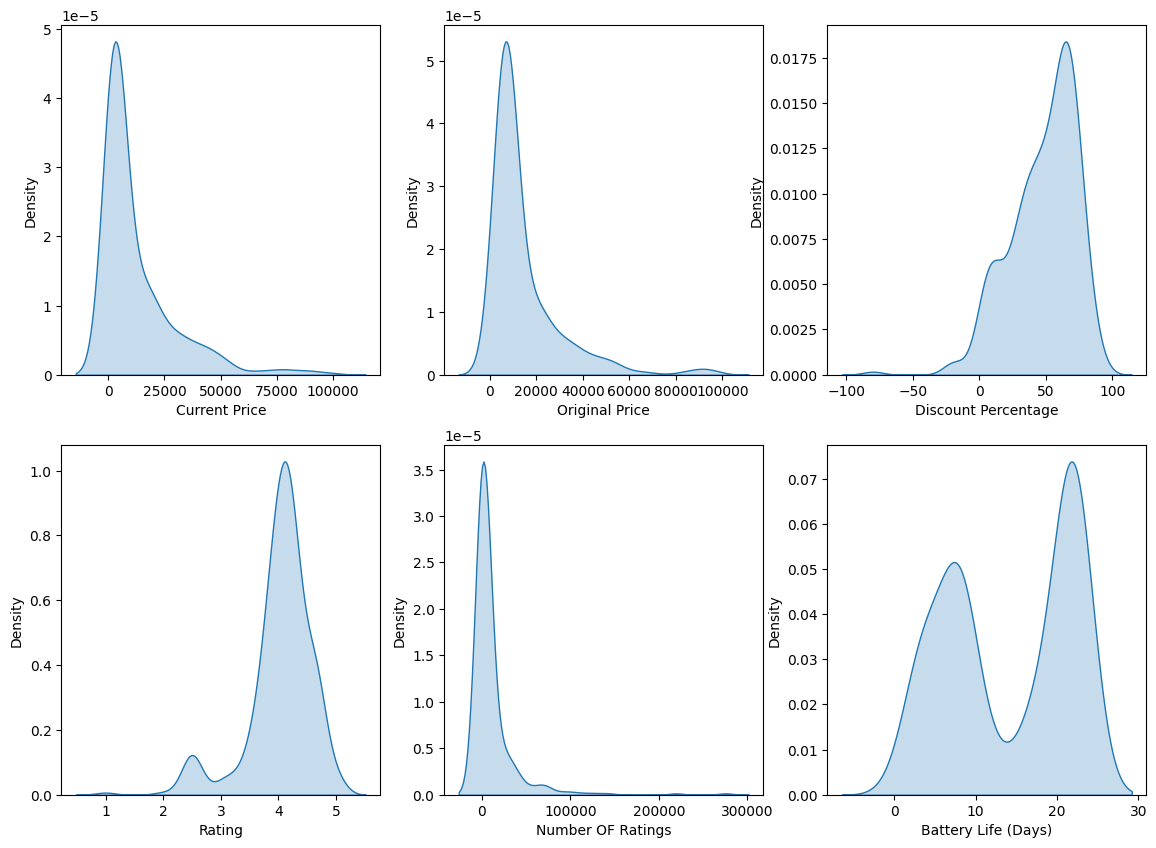

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))

for i, column in enumerate(numerical_data):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.kdeplot(data=train_df[column], ax=ax, fill=True)

plt.show()

Box and Whisker

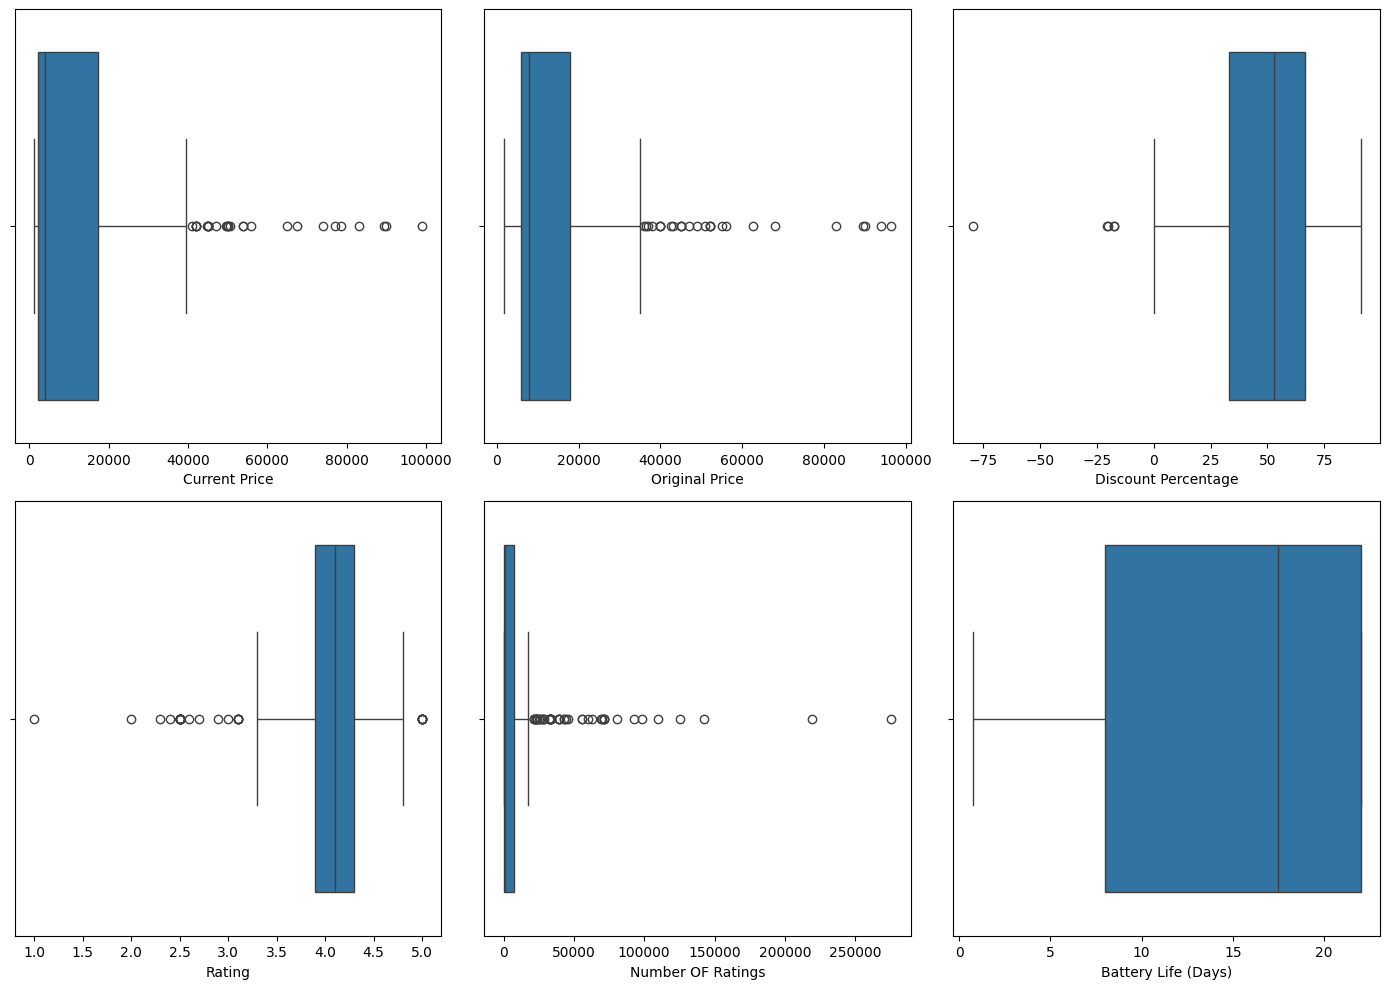

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))

for i, column in enumerate(numerical_data):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.boxplot(x=train_df[column], ax=ax)
  ax.set_xlabel(column)

fig.tight_layout()
plt.show()

## Multivariate Analysis

Now, let us look at the relationships between variables

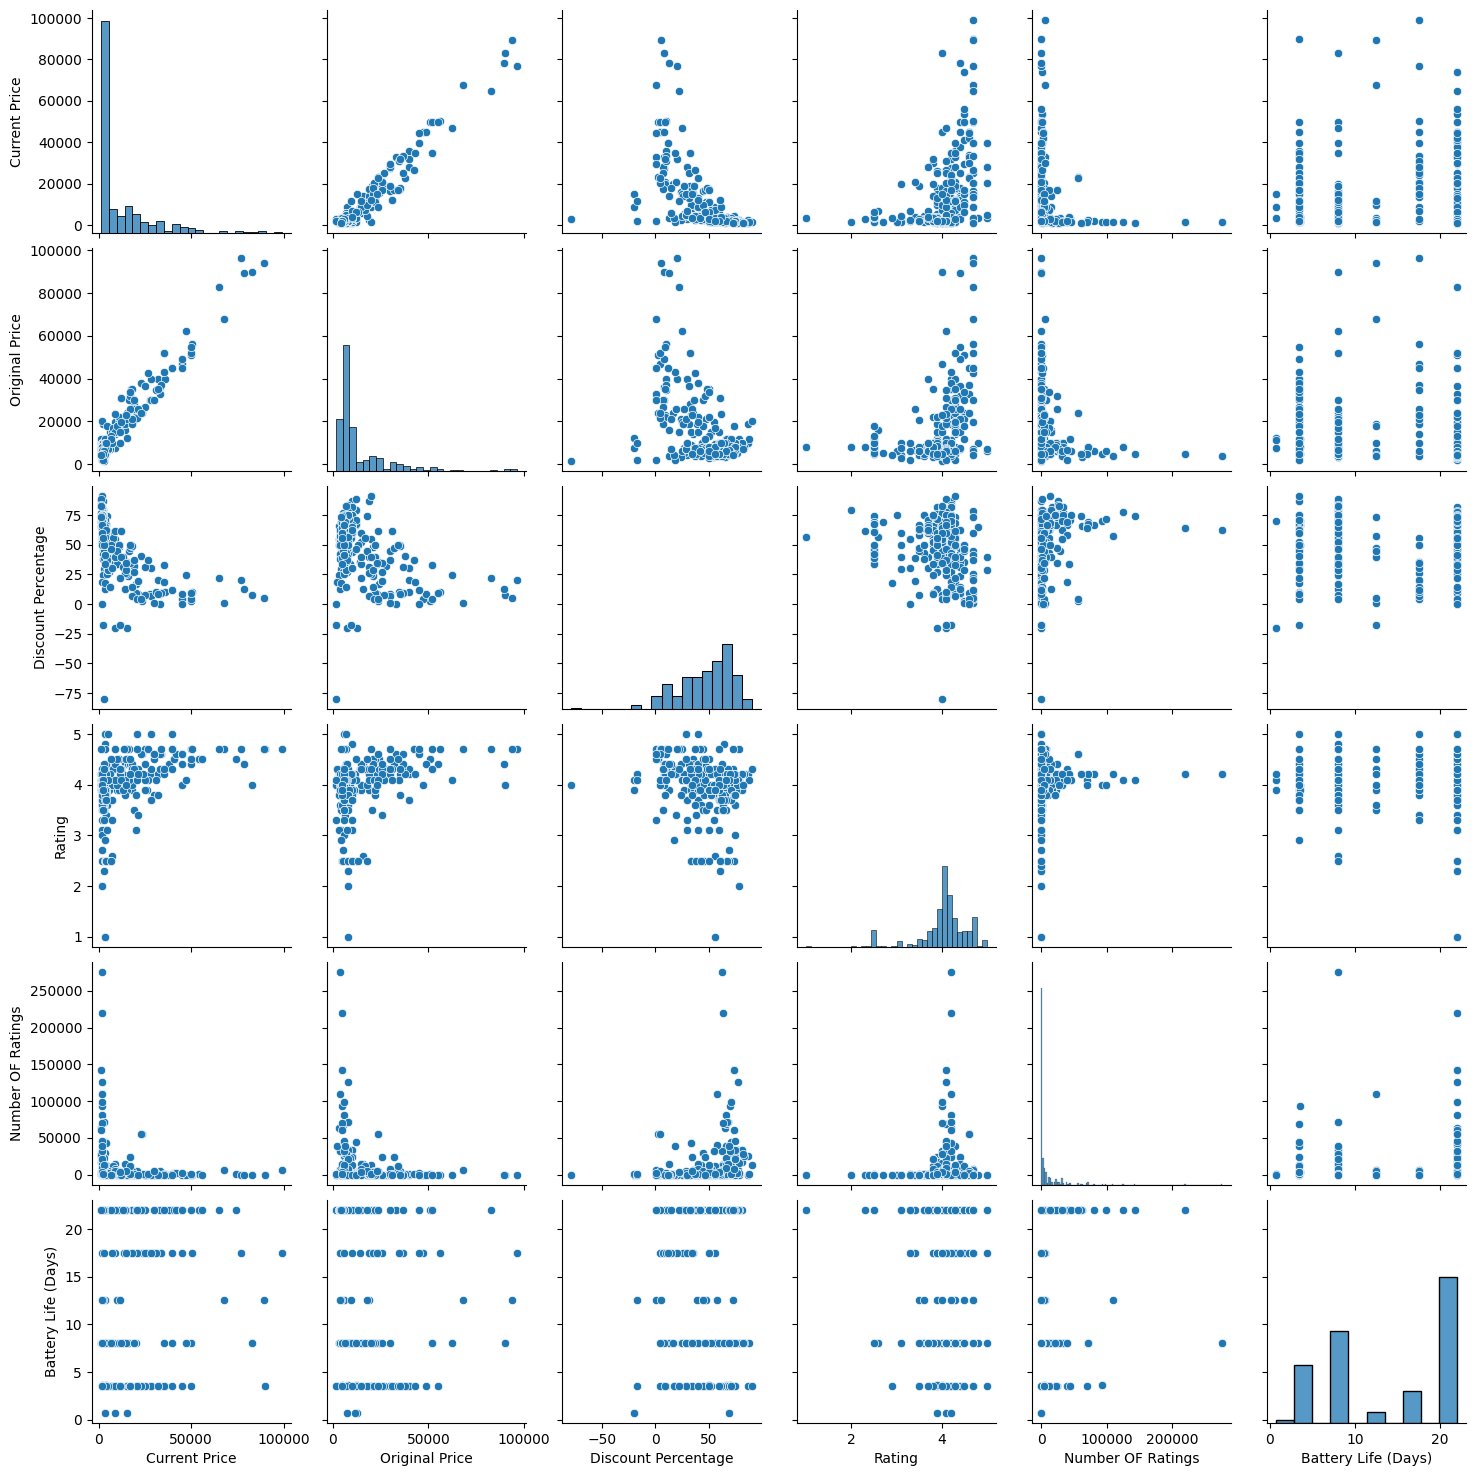

In [97]:
# Scatter Plot Matrix

sns.pairplot(train_df)

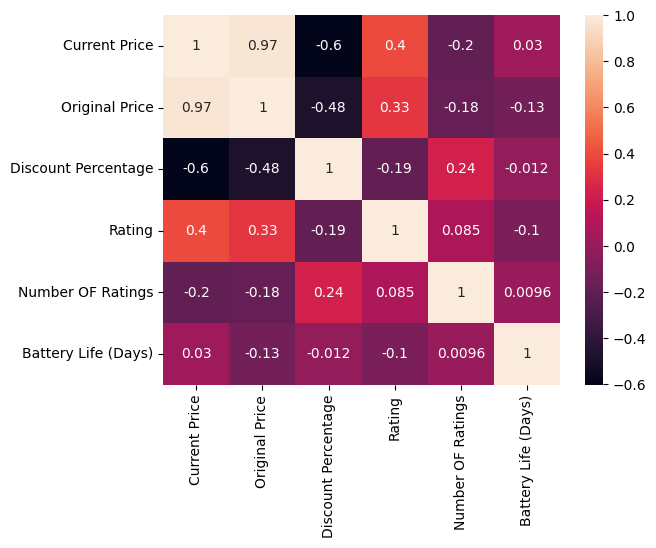

In [98]:
# Correlation Matrix

sns.heatmap(train_df[numerical_data].corr(), annot=True)
plt.show()

# Feature Engineering

Feature engineering is the process of transforming raw data into meaningful features that may improve the performance of machine learning models. It involves selecting, creating, and transforming variables to capture relevant information and enhance the predictive power of the model.

## Numerical Columns

**Display Size**

In [165]:
train_df['Display Size'].isna().sum()

27

In [166]:
train_df['Display Size'].value_counts().count()

34

In [167]:
train_df['Display Size'] = train_df['Display Size'].fillna('0.0 inches')

In [168]:
train_df['Display Size'] = train_df['Display Size'].apply(lambda x: float(x.split(' ')[0]))

In [169]:
train_df['Display Size'].head()

,Display Size
0,2.7
1,1.4
2,1.9
3,0.0
4,1.6


In [170]:
train_df['Display Size'] = train_df['Display Size'].replace(0.0, np.nan)

In [171]:
train_df['Display Size'].isna().sum()

28

**Weight**

In [172]:
train_df['Weight'].head()

,Weight
0,NaN
1,NaN
2,75g +
3,75g +
4,NaN


In [173]:
train_df['Weight'].value_counts()

,count
Weight,
20 - 35 g,63
75g +,58
35 - 50 g,45
<= 20 g,30
50 - 75 g,15


In [174]:
re.findall('\d+', '20 - 35 g')

['20', '35']

In [175]:
def calculate_average_weight(weight_string):
    """Calculates the average weight from a weight range string."""
    numbers = [int(num) for num in re.findall(r'\d+', weight_string)]
    if not numbers:  # Handle cases where no numbers are found
        return None  # Or raise an exception, depending on your needs
    if len(numbers) > 1:
        return sum(numbers) / len(numbers)  # Calculate average
    else:
        return numbers[0]  # Return the single number

# Define weight mappings
weight_mappings = {
    '20 - 35 g': calculate_average_weight('20 - 35 g'),
    '35 - 50 g': calculate_average_weight('35 - 50 g'),
    '50 - 75 g': calculate_average_weight('50 - 75 g'),
    '75g +': calculate_average_weight('75g +'),
    '<= 20 g': calculate_average_weight('<= 20 g'),
}

# Apply replacements
train_df['Weight'] = train_df['Weight'].replace(weight_mappings)

# Display value counts
print(train_df['Weight'].value_counts())

Weight
27.5    63
75.0    58
42.5    45
20.0    30
62.5    15
Name: count, dtype: int64


<ipython-input-175-40ac9a652486>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Weight'] = train_df['Weight'].replace(weight_mappings)


**Discount Price**

converting Discount Percentange into actual price

In [176]:
train_df['Discount Price'] = (train_df['Original Price'] * (-train_df['Discount Percentage'])) / 100

In [177]:
train_df.drop(['Discount Percentage'], axis=1, inplace=True)

In [178]:
numerical_data = [feature for feature in train_df.columns if train_df[feature].dtype != 'object']

In [179]:
numerical_data

['Current Price',
 'Original Price',
 'Rating',
 'Number OF Ratings',
 'Battery Life (Days)',
 'Display Size',
 'Weight',
 'Discount Price']

In [180]:
train_df[numerical_data].head()

,Current Price,Original Price,Rating,Number OF Ratings,Battery Life (Days),Display Size,Weight,Discount Price
0,2949.0,4199.0,3.1,10.0,NaN,2.7,NaN,-1250.000000
1,6999.0,15999.0,2.6,NaN,8.0,1.4,NaN,-8999.999999
2,2499.0,11999.0,4.1,1990.0,8.0,1.9,75.0,-9500.000000
3,1999.0,7990.0,3.6,827.0,8.0,NaN,75.0,-5991.000000
4,2299.0,5999.0,2.5,24.0,22.0,1.6,NaN,-3700.000000


**Removing  outliers**

In [181]:
def remove_outliers_IQR(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] > lower_bound) & (data[col] < upper_bound)]

In [182]:
import_col = ['Current Price', 'Original Price', 'Rating', 'Number OF Ratings', 'Display Size']

In [183]:
for col in import_col:
    train_df = remove_outliers_IQR(train_df, col)

In [184]:
for col in numerical_data:
    print(col)
    train_df[col].fillna(train_df[col].median(), inplace=True)

Current Price
Original Price
Rating
Number OF Ratings
Battery Life (Days)
Display Size
Weight
Discount Price


<ipython-input-184-3e922f1a3014>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)


In [185]:
train_df.isna().sum()

,0
Brand,0
Current Price,0
Original Price,0
Rating,0
Number OF Ratings,0
Model Name,9
Dial Shape,56
Strap Color,56
Strap Material,23
Touchscreen,6


In [186]:
train_df.shape

(143, 15)

## Normalization

Will brings features to a similar scale, preventing features with larger ranges from dominating those with smaller ranges.

In [187]:
from sklearn.preprocessing import MinMaxScaler

In [188]:
scaler = MinMaxScaler()

In [189]:
train_df[numerical_data].head()

,Current Price,Original Price,Rating,Number OF Ratings,Battery Life (Days),Display Size,Weight,Discount Price
2,2499.0,11999.0,4.1,1990.0,8.0,1.9,75.0,-9500.0
5,2499.0,6999.0,4.3,3944.0,22.0,1.9,42.5,-4500.0
6,3499.0,5999.0,4.2,1785.0,22.0,1.8,75.0,-2500.0
12,2126.0,5999.0,3.7,18.0,8.0,1.9,27.5,-3873.0
19,11499.0,18999.0,3.9,406.0,12.5,1.4,42.5,-7500.0


In [190]:
data = scaler.fit_transform(train_df[numerical_data[:-1]])

In [191]:
data

array([[0.06565657, 0.4683556 , 0.66666667, ..., 0.34117647, 0.66666667,
        1.        ],
       [0.06565657, 0.23720586, 0.83333333, ..., 1.        , 0.66666667,
        0.40909091],
       [0.11616162, 0.19097591, 0.75      , ..., 1.        , 0.58333333,
        1.        ],
       ...,
       [0.09090909, 0.19097591, 0.83333333, ..., 1.        , 0.5       ,
        0.40909091],
       [0.05050505, 0.        , 0.66666667, ..., 0.12941176, 0.33333333,
        0.        ],
       [0.53030303, 0.60704544, 0.83333333, ..., 0.12941176, 0.16666667,
        0.13636364]])

In [192]:
data = pd.DataFrame(data, columns=numerical_data[:-1])

In [193]:
data.head()

,Current Price,Original Price,Rating,Number OF Ratings,Battery Life (Days),Display Size,Weight
0,0.065657,0.468356,0.666667,0.059470,0.341176,0.666667,1.000000
1,0.065657,0.237206,0.833333,0.117952,1.000000,0.666667,0.409091
2,0.116162,0.190976,0.750000,0.053334,1.000000,0.583333,1.000000
3,0.046818,0.190976,0.333333,0.000449,0.341176,0.666667,0.136364
4,0.520202,0.791965,0.500000,0.012062,0.552941,0.250000,0.409091


In [194]:
data.shape, train_df.shape

((143, 7), (143, 15))

In [195]:
data.isna().sum()

,0
Current Price,0
Original Price,0
Rating,0
Number OF Ratings,0
Battery Life (Days),0
Display Size,0
Weight,0


In [196]:
train_df.drop(numerical_data[:-1], axis=1, inplace=True)

In [197]:
train_df.head()

,Brand,Model Name,Dial Shape,Strap Color,Strap Material,Touchscreen,Bluetooth,Discount Price
2,fire-boltt,BSW070,NaN,NaN,NaN,Yes,Yes,-9500.0
5,noise,"ColorFit Loop Advanced BT Calling with 1.85"" d...",Square,Grey,Silicon,Yes,Yes,-4500.0
6,dizo,Watch D Talk 1.8 display with calling&7 day ba...,Rectangle,Grey,Silicon,Yes,Yes,-2500.0
12,dizo,NaN,NaN,NaN,NaN,Yes,Yes,-3873.0
19,honor,MUS-B19,NaN,NaN,NaN,Yes,Yes,-7500.0


In [198]:
train_df = pd.concat([train_df.reset_index(), data], axis=1)

In [199]:
train_df[numerical_data]

,Current Price,Original Price,Rating,Number OF Ratings,Battery Life (Days),Display Size,Weight,Discount Price
0,0.065657,0.468356,0.666667,0.059470,0.341176,0.666667,1.000000,-9500.000000
1,0.065657,0.237206,0.833333,0.117952,1.000000,0.666667,0.409091,-4500.000000
2,0.116162,0.190976,0.750000,0.053334,1.000000,0.583333,1.000000,-2500.000000
3,0.046818,0.190976,0.333333,0.000449,0.341176,0.666667,0.136364,-3873.000000
4,0.520202,0.791965,0.500000,0.012062,0.552941,0.250000,0.409091,-7500.000000
...,...,...,...,...,...,...,...,...
138,0.696768,0.976700,0.583333,0.134084,0.788235,0.166667,0.409091,-8000.000001
139,0.040404,0.190976,0.666667,0.271699,0.341176,0.583333,0.409091,-4000.000000
140,0.090909,0.190976,0.833333,0.392224,1.000000,0.500000,0.409091,-3000.000000
141,0.050505,0.000000,0.666667,0.005327,0.129412,0.333333,0.000000,331.000000


## Categorical Columns

In [200]:
categorical_data = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
categorical_data

['Brand',
 'Model Name',
 'Dial Shape',
 'Strap Color',
 'Strap Material',
 'Touchscreen',
 'Bluetooth']

In [201]:
train_df[categorical_data].head()

,Brand,Model Name,Dial Shape,Strap Color,Strap Material,Touchscreen,Bluetooth
0,fire-boltt,BSW070,NaN,NaN,NaN,Yes,Yes
1,noise,"ColorFit Loop Advanced BT Calling with 1.85"" d...",Square,Grey,Silicon,Yes,Yes
2,dizo,Watch D Talk 1.8 display with calling&7 day ba...,Rectangle,Grey,Silicon,Yes,Yes
3,dizo,NaN,NaN,NaN,NaN,Yes,Yes
4,honor,MUS-B19,NaN,NaN,NaN,Yes,Yes


In [202]:
train_df['Bluetooth'].value_counts()

,count
Bluetooth,
Yes,143


In [203]:
# Remove 'Bluetooth' since it doesn't have group values
categorical_data.remove('Bluetooth')

In [204]:
from scipy.stats import f_oneway

In [205]:
# Chech the relationship between the categorical features (Brand, Model Name, etc.) and the 'Discount Price'
for col in categorical_data:
    CategoryGroupLists = train_df.groupby(col)['Discount Price'].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    print(col, ': ', 'P-Value for anova is: ', AnovaResults[1])

Brand :  P-Value for anova is:  1.9808914556041403e-11
Model Name :  P-Value for anova is:  0.00013438607111433278
Dial Shape :  P-Value for anova is:  0.013187855763808204
Strap Color :  P-Value for anova is:  0.01804089559250541
Strap Material :  P-Value for anova is:  0.000908149221135121
Touchscreen :  P-Value for anova is:  0.9592533579720977


In [206]:
imp_col = ['Brand', 'Model Name', 'Dial Shape', 'Strap Material']

In [207]:
train_df[imp_col].head()

,Brand,Model Name,Dial Shape,Strap Material
0,fire-boltt,BSW070,NaN,NaN
1,noise,"ColorFit Loop Advanced BT Calling with 1.85"" d...",Square,Silicon
2,dizo,Watch D Talk 1.8 display with calling&7 day ba...,Rectangle,Silicon
3,dizo,NaN,NaN,NaN
4,honor,MUS-B19,NaN,NaN


In [208]:
for col in imp_col:
  train_df[col] = train_df[col].fillna('other')

In [209]:
train_df[imp_col].isna().sum()

,0
Brand,0
Model Name,0
Dial Shape,0
Strap Material,0


In [210]:
brand = pd.get_dummies(train_df['Brand'], drop_first=True, dtype=int)

In [211]:
model_name = pd.get_dummies(train_df['Model Name'], dtype=int).drop(['other'], axis=1)
dial_shape = pd.get_dummies(train_df['Dial Shape'], dtype=int).drop(['other'], axis=1)
strap_material = pd.get_dummies(train_df['Strap Material'], dtype=int).drop(['other'], axis=1)

In [212]:
imp_df = pd.concat([brand, model_name, dial_shape, strap_material], axis=1)

In [213]:
imp_df.head()

,ambrane,boat,crossbeats,dizo,fire-boltt,fitbit,fossil,gizmore,hammer,honor,...,Fluoroelastomer,Leather,Metal,Nylon,Other,Plastic,Rubber,Silicon,Stainless Steel,Thermo Plastic Polyurethene
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [214]:
new_df = pd.concat([train_df[numerical_data], imp_df], axis=1)

In [215]:
new_df.head()

,Current Price,Original Price,Rating,Number OF Ratings,Battery Life (Days),Display Size,Weight,Discount Price,ambrane,boat,...,Fluoroelastomer,Leather,Metal,Nylon,Other,Plastic,Rubber,Silicon,Stainless Steel,Thermo Plastic Polyurethene
0,0.065657,0.468356,0.666667,0.059470,0.341176,0.666667,1.000000,-9500.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.065657,0.237206,0.833333,0.117952,1.000000,0.666667,0.409091,-4500.0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.116162,0.190976,0.750000,0.053334,1.000000,0.583333,1.000000,-2500.0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.046818,0.190976,0.333333,0.000449,0.341176,0.666667,0.136364,-3873.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.520202,0.791965,0.500000,0.012062,0.552941,0.250000,0.409091,-7500.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
new_df.isna().sum()

,0
Current Price,0
Original Price,0
Rating,0
Number OF Ratings,0
Battery Life (Days),0
...,...
Plastic,0
Rubber,0
Silicon,0
Stainless Steel,0


# Linear Regression Modeling

In [217]:
# Import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [218]:
# Separate the features and target variables
X = new_df.drop('Discount Price', axis=1)
y = new_df['Discount Price']

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

results = r2_score(y_test, y_pred)
print("R-squared:", results)

score = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
print("Cross-validation scores:", score, score.mean(), score.std())

R-squared: 1.0
Cross-validation scores: [1.         1.         0.95598895 0.74153481 1.        ] 0.9395047508725854 0.10044187661818983


In [221]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

results = r2_score(y_test, y_pred)
print("R-squared:", results)

score = cross_val_score(dt_model, X, y, cv=5, scoring='r2')
print("Cross-validation scores:", score, score.mean(), score.std())

R-squared: 0.18344953859875324
Cross-validation scores: [0.52159644 0.31673411 0.79035826 0.84949529 0.49770724] 0.5951782679666691 0.19759474181041006


In [222]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

results = r2_score(y_test, y_pred)
print("R-squared:", results)

score = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print("Cross-validation scores:", score, score.mean(), score.std())

R-squared: 0.5077466837654903
Cross-validation scores: [0.66994161 0.5469889  0.86076042 0.74389113 0.42287642] 0.6488916958809321 0.15219949370904876


In [223]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = r2_score(y_test, y_pred)
print("R-squared:", results)

score = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validation scores:", score, score.mean(), score.std())

R-squared: 0.6482703752932063
Cross-validation scores: [0.60123164 0.5568171  0.90312033 0.89291402 0.64828451] 0.72047352008913 0.1478572858992184


In [225]:
from sklearn.model_selection import GridSearchCV

In [226]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_model = xgb.XGBRegressor(**best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
R-squared: 0.6453794585168227


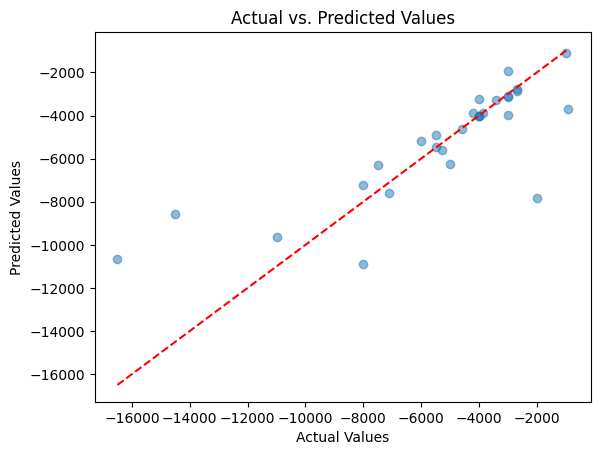

In [227]:
plt.scatter(y_test, y_pred, alpha=0.5)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle='--')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [228]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [229]:
with open('model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

In [231]:
y_pred = xgb_model.predict(X_test)

print(r2_score(y_test, y_pred))

0.6453794585168227
